## Rodando predições para todos modelos

In [1]:
model_arch = "dense-1b-arch1"
iters = [f"iter_00{d}" for d in range(10_000, 55_000, 5_000)]

In [2]:
for i in iters:
    !lm_eval \
        --model hf \
        --model_args pretrained=/hadatasets/morai/{model_arch}/,dtype=bfloat16,subfolder={i} \
        --tasks mmlu_var5shots_astronomy \
        --batch_size auto \
        --log_samples \
        --output_path results/{i}

2025-09-03:17:29:52 INFO     [__main__:440] Selected Tasks: ['mmlu_var5shots_astronomy']
2025-09-03:17:29:52 INFO     [evaluator:189] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-09-03:17:29:52 INFO     [evaluator:227] Initializing hf model, with arguments: {'pretrained': '/hadatasets/morai/dense-1b-arch1/', 'dtype': 'bfloat16', 'subfolder': 'iter_0010000'}
2025-09-03:17:29:56 INFO     [models.huggingface:137] Using device 'cuda'
2025-09-03:17:29:56 INFO     [models.huggingface:383] Model parallel was set to False, max memory was not set, and device map was set to {'': 'cuda'}
`torch_dtype` is deprecated! Use `dtype` instead!
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'hails/mmlu_no_train' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it 

## Carregando jsons

In [8]:
!pip install glob

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [40]:
json_list = glob("results/iter_*")
df = []
for folder in json_list:
    file = glob(f"{folder}/**/samples*")[0]
    df_j = pd.read_json(file, lines = True)
    checkpoint = int(folder.split("/")[-1].split("_")[-1])
    df_j["checkpoint"] = checkpoint
    df.append(df_j)

df = pd.concat(df).sort_values("checkpoint")

In [ ]:
def get_prob(row):
    target = row["doc"]["answer"]
    logits = np.array([float(row["resps"][i][0][0]) for i in range(4)])
    prob = np.exp(logits) / np.sum(np.exp(logits))
    prob = prob[target]
    return prob

df["prob"] = df.apply(get_prob, axis=1)

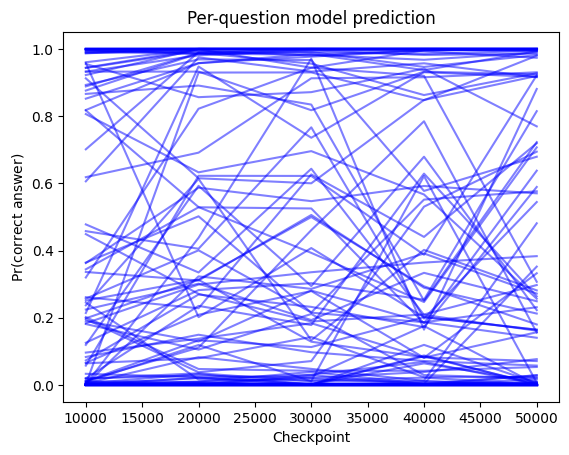

In [ ]:
def plot_fn(df_):
    plt.plot(df_["checkpoint"], df_["prob"], c = "blue", alpha = 0.5)

df.groupby("doc_id").apply(plot_fn, include_groups = False)
plt.xlabel("Checkpoint")
plt.ylabel("$\Pr($correct answer$)$")
plt.title("Per-question model prediction")
plt.show()